In [2]:
import numpy as np
import h5py
import numpy as np
from scipy.integrate import solve_ivp
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import torch
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader


In [ ]:
psi = np.load('/home/fabio/work/HM_and_AI_models/VAE_Model/x_stoch.npy')



print(psi.shape)

psi_one = psi[:, 0, :]  
print(psi_one.shape)
# # psi_one = psi_one[:, :]

psi_two = psi[:, 1, :]
# # psi_two  = psi_two[:, :]


psi = np.concatenate((psi_one, psi_two), axis=0)
psi = np.expand_dims(psi, axis=1)
print(psi.shape)



(299400, 2, 75)
(299400, 75)
(598800, 1, 75)


In [24]:
lead = 1

trainN = 400000
valN = 50000
index = 63

mean_psi = np.mean(psi, axis=0, keepdims=True)
std_psi = np.std(psi, axis=0, keepdims=True)
psi = (psi - mean_psi) / std_psi
# min_value = np.min(psi)
# psi = psi - min_value

print("mean_psi", std_psi.shape)


psi_train_input = torch.tensor(psi[0:trainN,:], dtype=torch.float32)
psi_train_shift_one =  torch.tensor(psi[lead:trainN+lead,:], dtype=torch.float32)

psi_val_input = torch.tensor(psi[trainN:trainN+valN,:], dtype=torch.float32)
psi_val_shift_one =  torch.tensor(psi[trainN+lead:trainN+valN+lead,:], dtype=torch.float32)

print(psi_train_input.shape)
print(psi_train_shift_one.shape)
print(psi_val_input.shape)
print(psi_val_shift_one.shape)


mean_psi (1, 1, 75)
torch.Size([400000, 1, 75])
torch.Size([400000, 1, 75])
torch.Size([50000, 1, 75])
torch.Size([50000, 1, 75])


In [25]:
hidden_dim = 64

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(75, 256)
        self.fc2 = nn.Linear(256, 256) 
        self.fc3 = nn.Linear(256, 256) 
        self.fc_mu = nn.Linear(256, latent_dim)  # Mean
        self.fc_logvar = nn.Linear(256, latent_dim)  # Variance

    def forward(self, x):
        x = torch.nn.functional.leaky_relu(self.fc1(x))  # Activation function RELU
        x = torch.nn.functional.leaky_relu(self.fc2(x))
        x = torch.nn.functional.leaky_relu(self.fc3(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar



class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim, condition_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim + condition_dim, 256)#Layer 1 256 Neurons
        self.fc2 = nn.Linear(256, 256)  # Layer 2 256 Neurons
        self.fc3 = nn.Linear(256, 256) # Layer 3 256 Neurons
        self.fc_output = nn.Linear(256, output_dim) 

    def forward(self, z, condition):
        z = torch.cat((z, condition), dim=2)  # Concatenate latent vector and condition
        z = torch.nn.functional.leaky_relu(self.fc1(z))  
        z = torch.nn.functional.leaky_relu(self.fc2(z))
        z = torch.nn.functional.leaky_relu(self.fc3(z))
        output = self.fc_output(z)
        return output




# Define the VAE model
class ConditionalVAE(nn.Module):
    def __init__(self, latent_dim, output_dim, condition_dim):
        super(ConditionalVAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim, output_dim, condition_dim)

    def encode(self, x):
        mu, logvar = self.encoder(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z, condition):
        return self.decoder(z, condition)

    def forward(self, x, condition):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        output = self.decode(z, condition)
        return output, mu, logvar

In [39]:
batch_size = 128

train_dataset = TensorDataset(psi_train_shift_one, psi_train_input)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TensorDataset(psi_val_shift_one, psi_val_input)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print(len(train_dataset))



400000


In [43]:
output_dim = 75
condition_dim = 75
latent_dim = 15
batch_size = 64
num_epochs = 10
learning_rate = .0001
kl_coef = .9

# Initialize the model, optimizer, and loss function
model = ConditionalVAE(latent_dim, output_dim, condition_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Order is important: we want the batch to yield (target, condition)
train_dataset = TensorDataset(psi_train_shift_one, psi_train_input)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TensorDataset(psi_val_shift_one, psi_val_input)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Training loop using the DataLoader
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for label_batch, input_batch in train_loader:
        # Move data to the correct device
        label_batch = label_batch.to(device)
        input_batch = input_batch.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass: note the ordering (target, condition) should match your model definition.
        reconstructed, mu, logvar = model(label_batch, input_batch)
        
        # Compute Reconstruction loss (here using simple MSE summed over all elements)
        reconstruction_loss = ((reconstructed - label_batch) ** 2).sum()
        
        # Compute KL divergence loss
        kl_loss = kl_coef * (mu.pow(2) + torch.exp(logvar) - 1 - logvar).sum()
        
        # Combine losses; note the KL term is weighted (0.01 factor here)
        loss = reconstruction_loss + 0.01 * kl_loss
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss}")
    print(f"Epoch {epoch+1}, Reconstruction Loss: {reconstruction_loss}")
    
    # Validation loop
    # model.eval()
    # running_val_loss = 0.0
    # with torch.no_grad():
    #     for label_batch, input_batch in val_loader:
    #         label_batch = label_batch.to(device)
    #         input_batch = input_batch.to(device)
            
    #         reconstructed, mu, logvar = model(label_batch, input_batch)
            
    #         reconstruction_loss = ((reconstructed - label_batch) ** 2).sum()
    #         kl_loss = kl_coef * (mu.pow(2) + torch.exp(logvar) - 1 - logvar).sum()
    #         loss = reconstruction_loss + 0.01 * kl_loss
            
    #         running_val_loss += loss.item()
    
    # avg_val_loss = running_val_loss / len(val_loader)
    # print(f"Epoch {epoch+1}, Validation Loss: {avg_val_loss}")


Epoch 1, Training Loss: 253.62082544265746
Epoch 1, Reconstruction Loss: 10.993917465209961
Epoch 2, Training Loss: 64.11763435447693
Epoch 2, Reconstruction Loss: 5.859703063964844
Epoch 3, Training Loss: 48.15124141937256
Epoch 3, Reconstruction Loss: 3.747559070587158
Epoch 4, Training Loss: 42.626302492294315
Epoch 4, Reconstruction Loss: 2.629570484161377
Epoch 5, Training Loss: 35.95843035118103
Epoch 5, Reconstruction Loss: 2.320807695388794
Epoch 6, Training Loss: 33.288472866516116
Epoch 6, Reconstruction Loss: 2.4177093505859375
Epoch 7, Training Loss: 32.511634971237186
Epoch 7, Reconstruction Loss: 2.3387703895568848
Epoch 8, Training Loss: 27.887552637939454
Epoch 8, Reconstruction Loss: 2.1216824054718018
Epoch 9, Training Loss: 27.025444008674622
Epoch 9, Reconstruction Loss: 2.2771339416503906
Epoch 10, Training Loss: 25.714650117416383
Epoch 10, Reconstruction Loss: 2.1169276237487793


In [44]:
model.parameters()

<generator object Module.parameters at 0x7f04d773fb50>

In [ ]:
# Initialize the model, optimizer, etc.
input_dim = 75       # Input dimension (75D vector)
latent_dim = 64      # Latent space size
output_dim = 75      # Output dimension (predicting next state)
condition_dim = 75   # Conditioning on psi[t]

model = ConditionalVAE(input_dim, latent_dim, output_dim, condition_dim, hidden_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def vae_loss(recon_x, x, mu, logvar, kl_weight=0.0001):
    # Reconstruction loss (MSE)
    recon_loss = nn.MSELoss()(recon_x, x)
    # KL Divergence loss, averaged over the batch
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.shape[0]
    return recon_loss + kl_weight * kl_loss


num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    train_input = psi_train_input.to(device)
    train_target = psi_train_shift_one.to(device)

    #Forward pass
    original_vector, mu, logvar = model(train_target, train_input)
    
    # Compute loss comparing output with psi_train_shift_one
    loss = vae_loss(original_vector, train_target, mu, logvar)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    if epoch % 3 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.9969
Epoch 3, Loss: 0.9801
Epoch 6, Loss: 0.9588
Epoch 9, Loss: 0.9251
Epoch 12, Loss: 0.8710
Epoch 15, Loss: 0.7887
Epoch 18, Loss: 0.6789
Epoch 21, Loss: 0.5859
Epoch 24, Loss: 0.5358
Epoch 27, Loss: 0.4515
Epoch 30, Loss: 0.3982
Epoch 33, Loss: 0.3500
Epoch 36, Loss: 0.3051
Epoch 39, Loss: 0.2716
Epoch 42, Loss: 0.2405
Epoch 45, Loss: 0.2145
Epoch 48, Loss: 0.1909


In [49]:
psi0 = np.array(psi[0])
print("Type:", type(psi0))
print("Shape:", psi0.shape)


# Ensure the initial condition has shape [batch, sequence, features]
initial_cond = torch.tensor(psi[0][0, :75], dtype=torch.float32).reshape(1, 1, 75).to(device)

time_steps = 40000
num_ens = 1
pred = np.zeros((time_steps, 75, num_ens))
model.eval()

for k in range(time_steps):
    for ens in range(num_ens):
        # Sample a latent vector with shape [1, 1, latent_dim]
        z = torch.randn((1, 1, latent_dim)).to(device)
        
        # Decode using the current condition; this will concatenate z and initial_cond along dim=2
        y = model.decode(z, initial_cond)
        
        # y now has shape [1, 1, 75]; remove the extra dimensions
        y_np = y.squeeze(0).squeeze(0).detach().cpu().numpy()  # now y_np is [75]
        pred[k, :, ens] = y_np
        
        # If you want to denormalize your output:
        y_denorm = (y_np * std_psi + mean_psi)
        
        # Prepare the new condition for the next step:
        # First re-normalize it if needed
        new_input = (y_denorm - mean_psi) / std_psi
        new_input = new_input[:, 0, :]

        # Now, new_input should have shape (75,) (or (1,75) – either way, adjust accordingly)
        initial_cond = torch.tensor(new_input, dtype=torch.float32).reshape(1, 1, 75).to(device)
    
    if k % 5000 == 0:
        print("Time step:", k)



Type: <class 'numpy.ndarray'>
Shape: (1, 75)
Time step: 0
Time step: 5000
Time step: 10000
Time step: 15000
Time step: 20000
Time step: 25000
Time step: 30000
Time step: 35000


In [54]:
# Denormalize final predictions:
std_reshaped = std_psi[:, 0, :].reshape(1, 75, 1)
mean_reshaped = mean_psi[:, 0, :].reshape(1, 75, 1)

pred_denorm = pred * std_reshaped + mean_reshaped

# For example, to compute the ensemble mean for feature 63:
pred_mean = np.mean(pred_denorm[:, 63, :], axis=1)  # shape: (time_steps,)
print("Ensemble mean prediction for feature 63:", pred_mean)
coutn = 0
for val in pred_mean:
    if val < 0:
        coutn += 1


print("Total Negatives: ", coutn)
# Convert the first time_steps of test labels to a numpy array and denormalize feature 63:
actual_values = psi_train_shift_one[:time_steps,0, 63].cpu().numpy() * std_psi[:, 0, 63] + mean_psi[:, 0, 63]
print("Actual values for feature 63:", actual_values)


Ensemble mean prediction for feature 63: [0.83517468 0.87600082 0.8530978  ... 1.05626202 1.07970655 1.09624732]
Total Negatives:  0
Actual values for feature 63: [ 0.86649853  0.88435549  0.87524438 ... -1.07797182 -1.06723559
 -1.05755472]


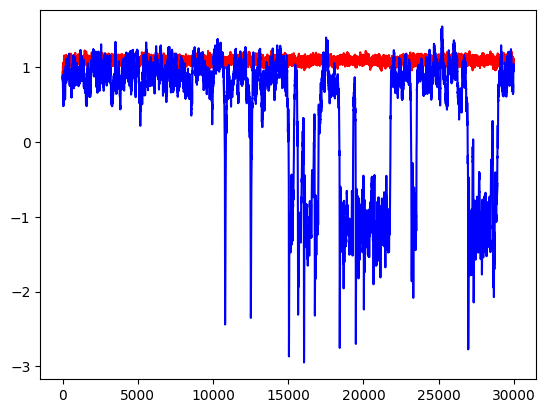

In [53]:
plt.plot(pred_mean[0:30000],'r')
plt.plot(actual_values[0:30000],'b')


In [ ]:
np.random.randint(0,9,1)

array([6])

In [ ]:
np.savez(r'/home/fabio/work/HM_and_AI_models/VAE_Model/predictions' ,
         predictions=pred_mean, mean_psi=mean_psi, std_psi=std_psi, actual_values=actual_values)